In [1]:
'''
Entry games: equilibrium computation
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def sigmoid(x):
    return 1/(1+np.exp(-x))

def compute_equilibrium(n_players, x, alpha, beta, gamma, epsilon=.0001, iter_cutoff=10000):
    # initialize probabilities
    sigma = .5*np.ones(n_players)
    # Do iterated best response until convergence to fixed point occurs
    t = 1
    while True: 
        sigma_n = np.zeros(n_players)
        for i in range(n_players):
            # Sum of probabilities of entry of opponents
            sigma_minus_i = np.sum(sigma[np.arange(n_players) != i])
            # Logistic best response
            sigma_n[i] = sigmoid(alpha[i] + beta[i] * sigma_minus_i + np.dot(gamma[i], x))

        # Check if L infinty norm of the two iterates is smaller than precision
        if np.linalg.norm(sigma_n - sigma, ord=np.inf) <= epsilon or t > iter_cutoff:
            break

        # Update probability vector to new vector
        for i in range(n_players):
            sigma[i] = sigma_n[i]

        # Increase iteration count
        t = t+1
    
    return sigma

def equilibrium_data(n_samples, n_dim, n_players, alpha, beta, gamma, sigma_x=1, epsilon=.0001, iter_cutoff=100):
    # Sample standard normal features
    x_samples = np.random.normal(0,sigma_x,(n_samples,n_dim))
    # Matrix of entry probability for each feature vector 
    sigma = .5*np.ones((n_samples, n_players))
    # Matrix of entry decisions for each feature vector
    y = np.zeros((n_samples, n_players))
    
    # Compute equilibrium probabilities for each feature vector
    for s in range(n_samples):
        sigma[s,:] = compute_equilibrium(n_players, x_samples[s], alpha, beta, gamma, epsilon, iter_cutoff)
        
    return x_samples, sigma

def equilibrium_sample_decision(sigma):
    # sample an entry decision
    return np.random.binomial(1, sigma)

def plot_equilibrium(x, sigma, title=""):
    n_dim = np.shape(x)[1]
    n_players = np.shape(sigma)[1]
    if n_dim == 2:
        for i in range(n_players):
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            surf = ax.plot_trisurf(x[:,0], x[:,1], sigma[:,i], 
                                  cmap=cm.RdBu,linewidth=0, antialiased=False)
            ax.zaxis.set_major_locator(LinearLocator(10))
            ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
            fig.colorbar(surf, shrink=0.5, aspect=5)
    else:
        fig = plt.figure()
        for d in range(n_dim):
            for i in range(n_players):
                plt.subplot(n_dim,n_players, d*n_players + i+1)
                plt.plot(x[:,d],sigma[:,i], 'o')
                plt.title(title)
    plt.show()

In [2]:
'''
Entry game: definition of parameters. Utility of each player is of the form: 
    u_i = alpha_i + beta_i \sum_{j\neq i} \sigma_j(x) + <gamma_i, x>
where alpha_i is a constant offset, beta_i is the interaction coefficient, gamma_i are the feature 
related coefficients, x is the feature vector, sigma_j(x) is the entry probability of player j
'''

n_dim = 1
n_players = 2
# Whether there is a feature independent fixed effect per player
has_intercept = False 
# Constant offset in players utility. If above is False these should be all zero
alpha = [0, 0]
# Market interaction coefficients
beta = [-.5, -.6]
# Feature related coefficients for each player
gamma = np.random.normal(0, 1, (n_players, n_dim))
print(gamma)
# Features are normally distributed with variance sigma_x
sigma_x = 10
# Number of samples for first stage
n_samples1 = 1000
# Number of samples for second stage
n_samples2 = 10000

[[-1.16764903]
 [ 0.76438467]]


In [3]:
'''
Generate data for first stage non-parametric estimation
'''

# Draw a sample of (feature, equilibrium) data points
x1, sigma1 = equilibrium_data(n_samples1, n_dim, n_players, alpha, beta, gamma, sigma_x=sigma_x)

In [4]:
# Draw a sample of entry decisions for the computed equilibrium
y1 = equilibrium_sample_decision(sigma1)

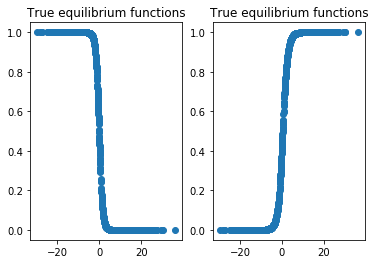

In [5]:
# Plot the equilibrium probability functions. Works mostly for one dimensional feature
plot_equilibrium(x1,sigma1, title="True equilibrium functions")

C:\Users\vasy\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


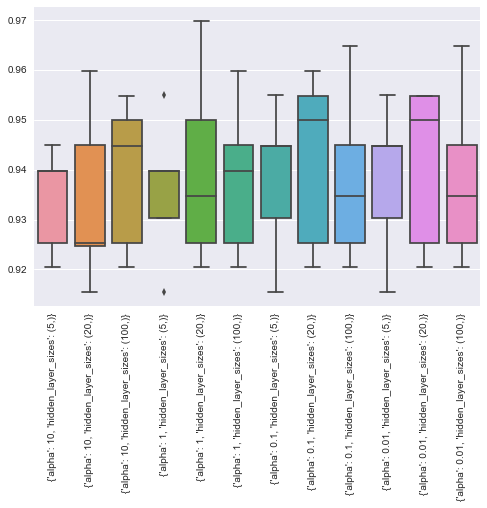

In [6]:
'''
Train first stage estimates
'''
import seaborn as sns, pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier

n_splits = 5
#param_grid = {'C': np.arange(1, 1000, 200)}
#estimator = linear_model.LogisticRegression()
#param_grid={"alpha": [10, 1, 1e-1, 1e-2], "gamma": [.1, .2, 1]}
#estimator = KernelRidge(kernel='rbf', gamma=0.1)
param_grid={"alpha": [10, 1, 1e-1, 1e-2], "hidden_layer_sizes": [(5,), (20,), (100,)]}
estimator = MLPClassifier(solver='adam', random_state=1, max_iter=10000)
gcv = GridSearchCV(estimator, param_grid,
                   n_jobs=1, iid=False, refit=True,
                   cv=n_splits)

first_stage_estimators = []
for i in range(n_players):
    gcv.fit(x1, y1[:, i])
    first_stage_estimators.append(gcv.best_estimator_)

# Plot score performance
def plot_performance(gcv):
    cv_scores = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        validation_scores = np.empty(n_splits, dtype=float)
        for j in range(n_splits):
            validation_scores[j] = gcv.cv_results_["split%d_test_score" % j][i]
        cv_scores.append(("{}".format(params), validation_scores))

    sns.boxplot(pd.DataFrame.from_items(cv_scores))
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

plot_performance(gcv)
plt.show()

In [7]:
'''
Generate second stage estimation data
'''

# Draw a sample of (feature, equilibrium) data points
x2, sigma2 = equilibrium_data(n_samples2, n_dim, n_players, alpha, beta, gamma, sigma_x=sigma_x)

In [8]:
# Draw a sample of entry decisions for the computed equilibrium
y2 = equilibrium_sample_decision(sigma2)

In [9]:
'''
Generate first stage estimates of entry probabilities for the new features
'''
sigma_hat = np.zeros((n_samples2, n_players))
for i in range(n_players):
    sigma_hat[:,i] = first_stage_estimators[i].predict_proba(x2)[:,1]

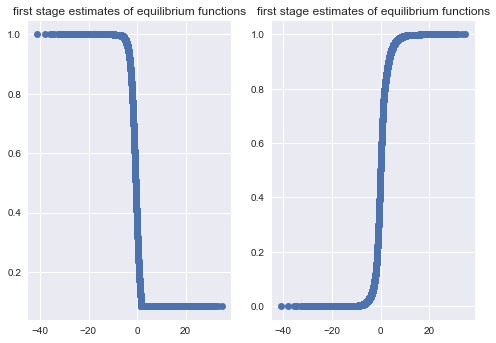

In [10]:
plot_equilibrium(x2, sigma_hat, title="first stage estimates of equilibrium functions")

In [11]:
'''
Train second stage estimator to recover estimated parameters
'''
alpha_est = np.zeros(n_players)
beta_est = np.zeros(n_players)
gamma_est = np.zeros((n_players, n_dim))
for i in range(n_players):
    sigma_hat_minus_i = np.sum(sigma_hat[:,np.arange(n_players) != i], axis = 1)
    extended_x = np.concatenate((x2, np.reshape(sigma_hat_minus_i, (np.shape(sigma_hat_minus_i)[0],1))),axis=1)
    estimator = linear_model.LogisticRegression(C=1000000, max_iter=10000, fit_intercept=has_intercept)
    estimator.fit(extended_x, y2[:,i])
    alpha_est[i] = estimator.intercept_
    beta_est[i] = estimator.coef_[0][-1]
    gamma_est[i] = estimator.coef_[0][:-1]

print(" {:^10} \t {:^10} \t {:^10}".format("Parameter","True", "Predicted"))
print("----------------------------------------------------------------")
for i in range(n_players):
    print("{:^10} \t {:^10.4f} \t {:^10.4f}".format("alpha[{}]".format(i), alpha[i], alpha_est[i]))
    print("{:^10} \t {:^10.4f} \t {:^10.4f}".format("beta[{}]".format(i), beta[i], beta_est[i]))
    print("{:^10} \t {} \t {}".format("gamma[{}]".format(i), gamma[i], gamma_est[i]))

 Parameter  	    True    	 Predicted 
----------------------------------------------------------------
 alpha[0]  	   0.0000   	   0.0000  
 beta[0]   	  -0.5000   	  -0.3625  
 gamma[0]  	 [-1.16764903] 	 [-1.174159]
 alpha[1]  	   0.0000   	   0.0000  
 beta[1]   	  -0.6000   	  -0.5328  
 gamma[1]  	 [ 0.76438467] 	 [ 0.73964198]


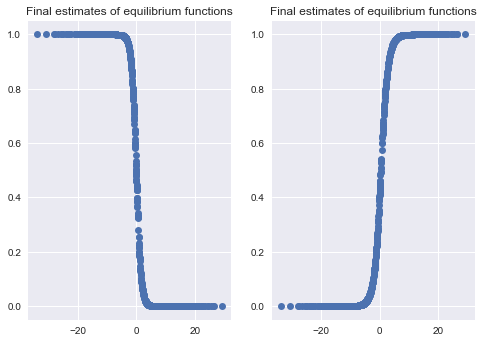

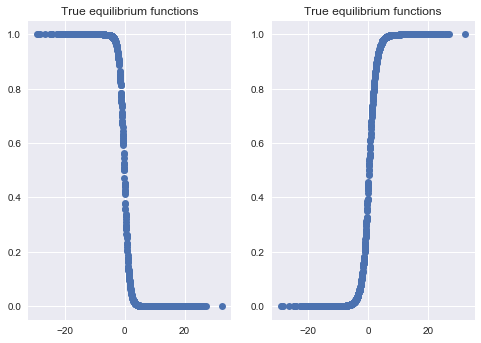

In [12]:
'''
Visualize final estimated equilibrium functions vs true equilibrium functions
'''
x3, sigma3_hat = equilibrium_data(1000, n_dim, n_players, alpha_est, beta_est, gamma_est, sigma_x=sigma_x)
plot_equilibrium(x3, sigma3_hat, title="Final estimates of equilibrium functions")
x4, sigma4 = equilibrium_data(1000, n_dim, n_players, alpha, beta, gamma, sigma_x=sigma_x)
plot_equilibrium(x4, sigma4, title="True equilibrium functions")

In [19]:
'''
Orthogonal moments based estimation. Currently works only for a one dimensional feature.

We need to minimize the norm of a set of empirical moments. This is norm of the vector of moments, were coordinate 0 is:
sigma_j(x) (y_i - G(gamma_i*x + beta_i * sigma_j(x)) - beta_i G'(gamma_i*x + beta_i * sigma_j(x)) (y_j - sigma_j(x)))
while the k-th coordinate is:
x[k] (y_i - G(gamma_i*x + beta_i * sigma_j(x)) - beta_i G'(gamma_i*x + beta_i * sigma_j(x)) (y_j - sigma_j(x)))
'''
from itertools import product

def moment(x, sigma, yi, yj, beta, gamma):
    ''' 
    Computes the value of the moment for a given player and state.
    
    Input:
    @x: a single state variable
    @sigma: the entry probability of your opponent at state x
    @yi: the entry decision of the player
    @yj: the entry decision of his opponent
    @beta: the market interaction coefficient
    @gamma: the state relevant coefficient
    '''
    G = sigmoid(beta * sigma + np.dot(x,gamma))
    multiplier = (yi - G - beta * G * (1-G) * (yj - sigma)) * G * (1-G)
    return np.concatenate((sigma[:,np.newaxis] * multiplier[:,np.newaxis], x * multiplier[:,np.newaxis]), axis=1)

def empirical_moment_vector(player_id, x, sigma, y, beta, gamma):
    '''
    Computes the empirical value of the moment vector for some player
    '''
    n_samples = np.shape(x)[0]
    if player_id == 0:
        moment_vec =  np.mean(moment(x,sigma[:,1],y[:,0],y[:,1],beta[0],gamma[0,:]), axis=0)
    else:
        moment_vec =  np.mean(moment(x,sigma[:,0],y[:,1],y[:,0],beta[1],gamma[1,:]), axis=0)
    return moment_vec

def empirical_moment_norm(player_id, x, sigma, y, beta, gamma):
    '''
    Computes the value of the norm of the empirical moment vector
    '''
    return np.linalg.norm(empirical_moment_vector(player_id, x, sigma, y, beta, gamma))

print("True parameters and moment norm for these parameters")
print(beta)
print(gamma)
print(empirical_moment_norm(0, x2, sigma2, y2, beta, gamma))
print(empirical_moment_norm(1, x2, sigma2, y2, beta, gamma))

t0 = time.time()

current_min0 = 1000
current_min1 = 1000
alpha_est = [0,0]
beta_est = [0,0]
gamma_est = [[0],[0]]
for beta_gr, gamma_gr  in product(*[np.arange(-1,1,.01),np.arange(-1,1,.01)]):
    norm0 = empirical_moment_norm(0, x2,sigma_hat,y2,[beta_gr,beta_gr],np.array([[gamma_gr],[gamma_gr]]))
    norm1 = empirical_moment_norm(1, x2,sigma_hat,y2,[beta_gr,beta_gr],np.array([[gamma_gr],[gamma_gr]]))
    if  norm0 <= current_min0:
        beta_est[0] = beta_gr
        gamma_est[0][0] = gamma_gr
        current_min0 = norm0
    if  norm1 <= current_min1:
        beta_est[1] = beta_gr
        gamma_est[1][0] = gamma_gr
        current_min1 = norm1

print("Feasible second stage estimates")
print(beta_est)
print(gamma_est)
print(current_min1)
print(current_min0)

t1 = time.time()
print(t1-t0)

True parameters and moment norm for these parameters
[-0.5, -0.6]
[[-1.16764903]
 [ 0.76438467]]
0.000111848968575
0.000857908729001
Feasible second stage estimates
[-0.69999999999999973, -0.48999999999999955]
[[-1.0], [0.72000000000000153]]
2.10707422317e-05
0.000867205689174
52.78661751747131


In [18]:
from scipy.optimize import basinhopping
import time

t0 = time.time()
init_point = [0,0]
minimizer_kwargs = {"method": "BFGS"}
ret0 = basinhopping(lambda x: empirical_moment_norm(0, x2,sigma_hat,y2,[x[0],x[0]],np.array([[x[1]],[x[1]]])), init_point, minimizer_kwargs=minimizer_kwargs, niter=50)
ret1 = basinhopping(lambda x: empirical_moment_norm(1, x2,sigma_hat,y2,[x[0],x[0]],np.array([[x[1]],[x[1]]])), init_point, minimizer_kwargs=minimizer_kwargs, niter=50)
beta_est = [ret0.x[0], ret1.x[0]]
gamma_est = np.array([[ret0.x[1]], [ret1.x[1]]])
print(beta_est)
print(gamma_est)
print(ret0.fun)
print(ret1.fun)
t1 = time.time()
print(t1-t0)

C:\Users\vasy\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: overflow encountered in exp


[-0.43692566768281804, -0.50206916800573431]
[[-1.15486608]
 [ 0.71775608]]
2.6530557369459784e-12
1.1905153388933536e-11
28.659876108169556


In [39]:
from scipy.optimize import basinhopping, minimize
import time

t0 = time.time()
init_point = np.zeros(n_dim+1)
ret0 = minimize(lambda x: empirical_moment_norm(0, x2,sigma_hat,y2,[x[0],x[0]],np.array([x[1:],x[1:]])), init_point, method='BFGS')
ret1 = minimize(lambda x: empirical_moment_norm(1, x2,sigma_hat,y2,[x[0],x[0]],np.array([x[1:],x[1:]])), init_point, method='BFGS')
beta_est = [ret0.x[0], ret1.x[0]]
gamma_est = np.array([ret0.x[1:], ret1.x[1:]])
print(beta_est)
print(gamma_est)
print(ret0.fun)
print(ret1.fun)
t1 = time.time()
print(t1-t0)

[-0.43692566700639562, -0.50206924857877155]
[[-1.15486608]
 [ 0.71775607]]
3.2099145228276522e-12
1.2821655211672943e-10
0.7765002250671387


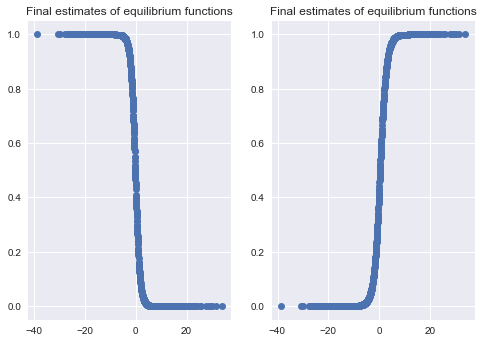

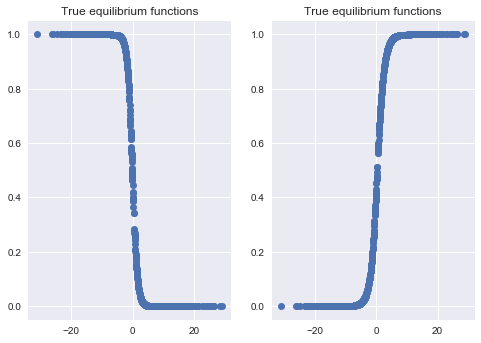

In [14]:
'''
Visualize final estimated equilibrium functions vs true equilibrium functions
'''
x3, sigma3_hat = equilibrium_data(1000, n_dim, n_players, alpha_est, beta_est, gamma_est, sigma_x=sigma_x)
plot_equilibrium(x3, sigma3_hat, title="Final estimates of equilibrium functions")
x4, sigma4 = equilibrium_data(1000, n_dim, n_players, alpha, beta, gamma, sigma_x=sigma_x)
plot_equilibrium(x4, sigma4, title="True equilibrium functions")

In [15]:
'''
Infeasible second stage estimator that gets the true equilibrium probabilities of opponent as input
'''

current_min0 = 1000
current_min1 = 1000
alpha_est = [0,0]
beta_est = [0,0]
gamma_est = [[0],[0]]
for beta_gr, gamma_gr  in product(*[np.arange(-1,1,.01),np.arange(-1,1,.01)]):
    norm0 = empirical_moment_norm(0, x2,sigma2,y2,[beta_gr,beta_gr],np.array([[gamma_gr],[gamma_gr]]))
    norm1 = empirical_moment_norm(1, x2,sigma2,y2,[beta_gr,beta_gr],np.array([[gamma_gr],[gamma_gr]]))
    if  norm0 <= current_min0:
        beta_est[0] = beta_gr
        gamma_est[0][0] = gamma_gr
        current_min0 = norm0
    if  norm1 <= current_min1:
        beta_est[1] = beta_gr
        gamma_est[1][0] = gamma_gr
        current_min1 = norm1

print("Feasible second stage estimates")
print(beta_est)
print(gamma_est)
print(current_min1)
print(current_min0)

Feasible second stage estimates
[-0.72999999999999976, -0.48999999999999955]
[[-1.0], [0.72000000000000153]]
2.85873706829e-05
0.000847780187689


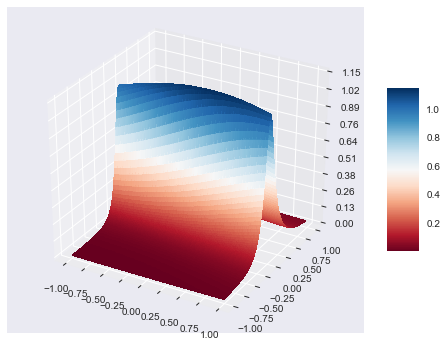

In [35]:
from itertools import product

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
b_gr = np.arange(-1,1,0.01)
g_gr = np.arange(-1,1,0.01)
obj = np.array([empirical_moment_norm(0, x2,sigma_hat,y2,[b,b],np.array([[g],[g]])) for (b,g) in product(*[b_gr,g_gr])])
points = np.array(list(product(*[b_gr,g_gr])))
surf = ax.plot_trisurf(points[:,0], points[:,1], obj, 
                      cmap=cm.RdBu, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()